In [1]:
import cobra
import cobra.test
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
import pandas as pd
import math
import random
from os import walk

pd.options.mode.chained_assignment = None  # default='warn'


In [13]:
### Western diet model 
file_name = "Lactobacillus_rhamnosus_GG_ATCC_53103.mat"
modelWE = cobra.io.load_matlab_model("Agora-1.02-Western/mat/" + file_name)
modelWE

Name,model
Memory address,0x0107ea2d68
Number of metabolites,1011
Number of reactions,1138
Objective expression,-1.0*biomass205_reverse_3c9be + 1.0*biomass205
Compartments,"c, e"


In [14]:
### High fiber diet model 
modelHF = cobra.io.load_matlab_model("Agora-1.02-HighFiber/mat/" + file_name)
modelHF

Name,model
Memory address,0x01a211792b0
Number of metabolites,1011
Number of reactions,1138
Objective expression,-1.0*biomass205_reverse_3c9be + 1.0*biomass205
Compartments,"c, e"


In [ ]:
# Iterate through the the objects in the model
def printModelObjects(model):
    print("Reactions")
    print("---------")
    for x in model.reactions:
        print("%s : %s" % (x.id, x.reaction))

    print("")
    print("Metabolites")
    print("-----------")
    for x in model.metabolites:
        print('%9s : %s' % (x.id, x.formula))

    print("")
    print("Genes")
    print("-----")
    for x in model.genes:
        associated_ids = (i.id for i in x.reactions)
        print("%s is associated with reactions: %s" %
              (x.id, "{" + ", ".join(associated_ids) + "}"))

printModelObjects(modelHF)

In [15]:
# Iterate through the the objects in the model
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def printModelObjects(model):
    with open("Output{m}.txt".format(m=namestr(model, globals())), "w") as text_file:
#     print("Purchase Amount: {}".format(TotalAmount), file=text_file)
        print("Reactions", file=text_file)
        print("---------", file=text_file)
        for x in model.reactions:
            print("%s : %s" % (x.id, x.reaction), file=text_file)

        print("", file=text_file)
        print("Metabolites", file=text_file)
        print("-----------", file=text_file)
        for x in model.metabolites:
            print('%9s : %s' % (x.id, x.formula), file=text_file)

        print("", file=text_file)
        print("Genes", file=text_file)
        print("-----", file=text_file)
        for x in model.genes:
            associated_ids = (i.id for i in x.reactions)
            print("%s is associated with reactions: %s" %
                  (x.id, "{" + ", ".join(associated_ids) + "}"), file=text_file)

printModelObjects(modelHF)
printModelObjects(modelWE)

In [2]:
## Experiment 1: Compare growth rates between the different diets
def get_growthRate(model):
    # Set no oxygen uptake
    modelHF.reactions.get_by_id("EX_o2(e)").lower_bound = 0.
    # ensure that the biomass reaction is set as the objective function
    modelHF.objective = "EX_biomass(e)"
    return model.optimize().objective_value

# print("Growth rate with western Diet: {gr}".format(gr=get_growthRate(modelEU)))
# print("Growth rate with high fiber Diet: {gr}".format(gr=get_growthRate(modelHF)))

In [3]:
## Experiment 1-LargeScale

file_names = []
for (dirpath, dirnames, filenames) in walk("Agora-1.02-Western/mat/"):
    file_names.extend(filenames)
    break
random.shuffle(file_names)
print(len(file_names))

818


In [31]:
# col_microbiome = ['species_name', 'WE_growth', 'HF_growth']
# microbiomeDB = pd.DataFrame(columns=col_microbiome)

microbiomeDB = pd.read_excel("microbiomeDB_results.xlsx")
# microbiomeDB.head()

In [20]:
for i in range(len(file_names)):
    if file_names[i][:-4] not in microbiomeDB.species_name.tolist():
        MBRow = len(microbiomeDB)
        microbiomeDB.loc[MBRow] = [0 for _ in range(len(microbiomeDB.columns))]

        microbiomeDB.species_name[MBRow] = file_names[i][:-4]
        modelWE = cobra.io.load_matlab_model("Agora-1.02-Western/mat/" + file_names[i])
        modelHF = cobra.io.load_matlab_model("Agora-1.02-HighFiber/mat/" + file_names[i])
        microbiomeDB.WE_growth[MBRow] = get_growthRate(modelWE)
        microbiomeDB.HF_growth[MBRow] = get_growthRate(modelHF)
        print("Done with {i}/{tot} - WE: {WE}; HF: {HF}".format(i=MBRow, tot=len(file_names), WE=microbiomeDB.WE_growth[MBRow], HF=microbiomeDB.HF_growth[MBRow]))
        microbiomeDB.to_excel("microbiomeDB_resultsW-HF.xlsx")



In [22]:
for i in range(len(microbiomeDB)):
    if microbiomeDB.WE_growth[i] == 0:
        modelWE = cobra.io.load_matlab_model("Agora-1.02-Western/mat/" + microbiomeDB.species_name[i] + ".mat")
        microbiomeDB.WE_growth[i] = get_growthRate(modelWE)
        print("Done with {i}/{tot} - WE: {WE}; HF: {HF}".format(i=i, tot=len(microbiomeDB), WE=microbiomeDB.WE_growth[i], HF=microbiomeDB.HF_growth[i]))
        microbiomeDB.to_excel("microbiomeDB_results.xlsx")


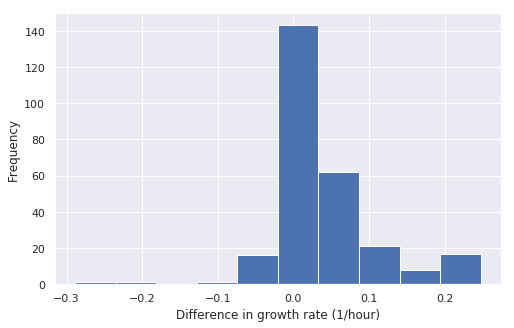

In [19]:
microbiomeDB = pd.read_excel("microbiomeDB_results.xlsx")
microbiomeDB["d_growth"] = microbiomeDB.WE_growth - microbiomeDB.HF_growth

fig, ax = plt.subplots(figsize=(8, 5))
microbiomeDB.hist(column="d_growth", ax=ax)
ax.set_title("")
ax.set_xlabel("Difference in growth rate (1/hour)")
ax.set_ylabel("Frequency")
fig.savefig('figure1.png', dpi=1000)

In [39]:
# Histogram by phylum
modelInfo = pd.read_excel("ModelInformation.xlsx")
# microbiomeDB["phylum"] = microbiomeDB.species_name.map(modelInfo.Phylum)
# microbiomeDB.head()

microbiomeDB = microbiomeDB.merge(modelInfo[["ModelAGORA", "Phylum"]], left_on="species_name", right_on="ModelAGORA", how="left")
microbiomeDB.head()
microbiomeDB.to_excel("microbiomeDB_results_wPhylum.xlsx")

Text(0, 0.5, 'Frequency')

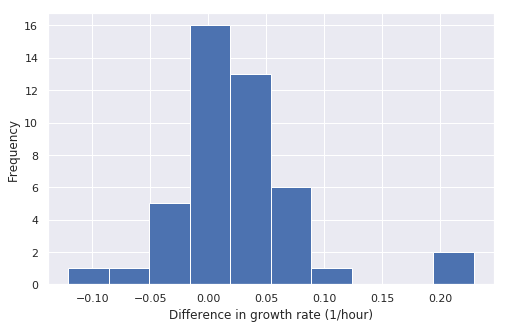

In [44]:
microbiomeDB["d_growth"] = microbiomeDB.WE_growth - microbiomeDB.HF_growth
fig, ax = plt.subplots(figsize=(8, 5))
microbiomeDB[microbiomeDB.Phylum_x == "Actinobacteria"].hist(column="d_growth", ax=ax)
ax.set_title("")
ax.set_xlabel("Difference in growth rate (1/hour)")
ax.set_ylabel("Frequency")
# fig.savefig('figure2.png', dpi=1000)



Text(0.5, 0, 'Difference in growth rate (1/hour)')

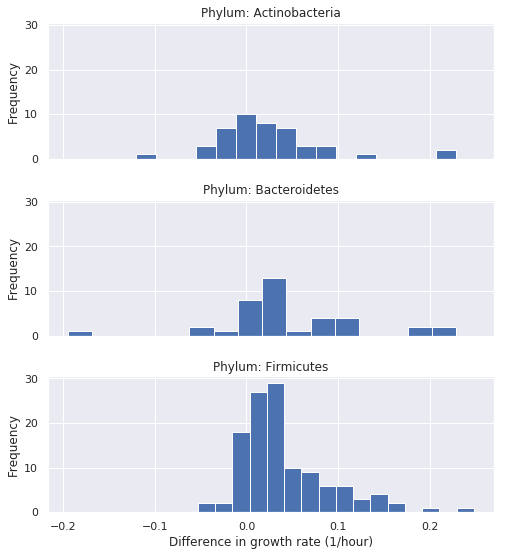

In [55]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True, sharex=True, figsize=(8, 9))

axes = [ax1, ax2, ax3]
phyl = ["Actinobacteria", "Bacteroidetes", "Firmicutes"]

for i in range(3):
    microbiomeDB[microbiomeDB.Phylum_x == phyl[i]].hist(column="d_growth", ax=axes[i], bins=16)
    axes[i].set_title("Phylum: " + phyl[i])
    axes[i].set_ylabel("Frequency")
ax3.set_xlabel("Difference in growth rate (1/hour)")

# f.savefig('figure2.png', dpi=1000)

In [57]:
## Experiment 2: Robustness Analysis by diet

def robustness_byDiet(modelWE, modelHF):
#     modelWE = cobra.io.load_matlab_model("Agora-1.02-Western/mat/" + file_name)
#     modelHF = cobra.io.load_matlab_model("Agora-1.02-HighFiber/mat/" + file_name)

    modelWE.reactions.get_by_id("EX_o2(e)").lower_bound = 0
    modelWE.reactions.get_by_id("EX_o2(e)").upper_bound = 0
    modelHF.reactions.get_by_id("EX_o2(e)").lower_bound = 0
    modelHF.reactions.get_by_id("EX_o2(e)").upper_bound = 0
    
    ratesWE = []
    ratesHF = []
    
    for i in range(20):
        modelWE.reactions.get_by_id("EX_glc_D(e)").lower_bound = -i
        modelWE.reactions.get_by_id("EX_glc_D(e)").upper_bound = -i
        modelWE.objective = "EX_biomass(e)"
        ratesWE.append(modelWE.optimize().objective_value)
        modelHF.reactions.get_by_id("EX_glc_D(e)").lower_bound = -i
        modelHF.reactions.get_by_id("EX_glc_D(e)").upper_bound = -i
        modelHF.objective = "EX_biomass(e)"
        ratesHF.append(modelHF.optimize().objective_value)
    return ratesWE, ratesHF
    
file_name = "Bacteroides_caccae_ATCC_43185.mat"
modelWE = cobra.io.load_matlab_model("Agora-1.02-Western/mat/" + file_name)
modelHF = cobra.io.load_matlab_model("Agora-1.02-HighFiber/mat/" + file_name)
ratesWE, ratesHF = robustness_byDiet(modelWE, modelHF)

Growth rate with western Diet: 0.861879649194333
Growth rate with high fiber Diet: 0.8618796491942655


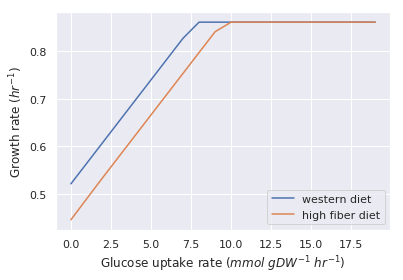

In [70]:
print("Growth rate with western Diet: {gr}".format(gr=get_growthRate(modelWE)))
print("Growth rate with high fiber Diet: {gr}".format(gr=get_growthRate(modelHF)))
# print(ratesWE)
# print(ratesHF)

plt.plot(ratesWE, label="western diet")
plt.plot(ratesHF, label="high fiber diet")
plt.xlabel(r"Glucose uptake rate ($mmol$ $gDW^{-1}$ $hr^{-1}$)")
plt.ylabel(r"Growth rate ($hr^{-1}$)")
plt.legend()
# plt.show()
plt.savefig('figure3.png', dpi=1000)
